# Exploratory Data Analysis - Engagement Time Series

This notebook explores the synthetic engagement time series data to understand:
- Distribution of engagement metrics (views, likes, comments, shares)
- Differences between normal and fake engagement patterns
- Temporal patterns and anomalies
- Class balance and data quality


In [1]:
%matplotlib inlineimport sysfrom pathlib import Path# add project root to pathproject_root = Path().resolve().parentsys.path.insert(0, str(project_root))# create output directory for plotsoutput_dir = project_root / "outputs" / "figures"output_dir.mkdir(parents=True, exist_ok=True)import pandas as pdimport numpy as npimport matplotlib.pyplot as pltimport seaborn as snsfrom datetime import datetimeimport warningswarnings.filterwarnings('ignore')# set plotting styletry:    plt.style.use('seaborn-v0_8-darkgrid')except OSError:    try:        plt.style.use('seaborn-darkgrid')    except OSError:        plt.style.use('default')sns.set_palette("husl")plt.rcParams['figure.figsize'] = (14, 8)plt.rcParams['font.size'] = 10plt.rcParams['axes.labelsize'] = 12plt.rcParams['axes.titlesize'] = 14plt.rcParams['figure.dpi'] = 100plt.rcParams['savefig.dpi'] = 150plt.rcParams['savefig.bbox'] = 'tight'# import project modulesfrom src.data.load_data import load_datafrom src.data.make_dataset import main as generate_dataset_mainfrom src.visualization.plots import plot_series_with_anomalies# import IPython display for showing saved imagestry:    from IPython.display import Image, display    HAS_IPYTHON = Trueexcept ImportError:    HAS_IPYTHON = False

## 1. Generate and Load Data

First, we generate a synthetic dataset with normal and fake engagement patterns.


In [2]:
# load datasetdata_path = project_root / "data" / "raw" / "engagement.parquet"# generate if it doesn't existif not data_path.exists():    print("Generating dataset...")    import subprocess    subprocess.run([        "python", "-m", "src.data.make_dataset",        "--n_users", "500",        "--length", "336",        "--fake_ratio", "0.35"    ], cwd=str(project_root))    print("Dataset generated!")else:    print(f"Loading existing dataset from {data_path}")# load datasetdf = load_data(data_path)# adapt column names if neededif 'user_id' in df.columns and 'id' not in df.columns:    df['id'] = df['user_id']if 'is_fake_series' in df.columns and 'label' not in df.columns:    df['label'] = df['is_fake_series'].map({True: 'fake', False: 'normal'})print(f"\nDataset shape: {df.shape}")print(f"Columns: {df.columns.tolist()}")if 'is_fake_series' in df.columns:    print(f"\nFake series distribution:")    print(df['is_fake_series'].value_counts())    print(f"Fake ratio: {df['is_fake_series'].mean():.2%}")if 'label' in df.columns:    print(f"\nLabel distribution:")    print(df['label'].value_counts())print(f"\nNumber of unique users: {df['id'].nunique()}")if 'profile' in df.columns:    print(f"\nProfile distribution:")    print(df['profile'].value_counts())if 'attack_type' in df.columns:    print(f"\nAttack type distribution (fake only):")    fake_df = df[df.get('is_fake_series', df.get('label') == 'fake')]    if len(fake_df) > 0:        print(fake_df['attack_type'].value_counts())

Loading existing dataset from C:\Users\leila\tiktok-ml-fraude\fake-engagement-detection-ml-time-series\data\raw\engagement.parquet



Dataset shape: (33600, 12)
Columns: ['user_id', 'timestamp', 'views', 'likes', 'comments', 'shares', 'is_fake_series', 'is_anomaly_window', 'profile', 'attack_type', 'id', 'label']

Fake series distribution:
is_fake_series
False    24528
True      9072
Name: count, dtype: int64
Fake ratio: 27.00%

Label distribution:
label
normal    24528
fake       9072
Name: count, dtype: int64

Number of unique users: 100

Profile distribution:
profile
new           5712
regular       5040
impulsive     4704
power         4704
influencer    4704
dormant       4704
casual        4032
Name: count, dtype: int64

Attack type distribution (fake only):
attack_type
boost_progressive    3024
perfect_sync         2352
off_peak_bursts      1344
single_spike         1344
wave_spam             672
bursts_small          336
Name: count, dtype: int64


## 2. Data Overview

Basic statistics and data quality checks.


In [3]:
# define metricsmetrics = ['views', 'likes', 'comments', 'shares']# ensure label column existsis_fake_col = df.get('is_fake_series', None)if is_fake_col is None:    is_fake_col = (df.get('label', pd.Series(['normal'] * len(df))) == 'fake')if 'label' not in df.columns:    df['label'] = is_fake_col.map({True: 'fake', False: 'normal'})# basic statistics by labelprint("Summary statistics by label:\n")print(df.groupby('label')[metrics].describe())# check for missing valuesprint("\nMissing values:")print(df[metrics].isna().sum())# check data typesprint("\nData types:")print(df[metrics + ['timestamp']].dtypes)

Summary statistics by label:

          views                                                         likes  \
          count       mean         std  min  25%   50%   75%     max    count   
label                                                                           
fake     9072.0  53.098325  103.036894  0.0  5.0  16.0  58.0  2244.0   9072.0   
normal  24528.0  35.622921   54.429007  0.0  5.0  16.0  39.0  1345.0  24528.0   

                  ... comments         shares                                \
            mean  ...      75%   max    count      mean       std  min  25%   
label             ...                                                         
fake    4.022597  ...      1.0  30.0   9072.0  0.993937  2.183881  0.0  0.0   
normal  2.425228  ...      0.0  10.0  24528.0  0.660429  1.284573  0.0  0.0   

                        
        50%  75%   max  
label                   
fake    0.0  1.0  38.0  
normal  0.0  1.0  31.0  

[2 rows x 32 columns]

Missing values:
vie

## 3. Distribution Analysis - Histograms

Compare the distribution of engagement metrics between normal and fake patterns.


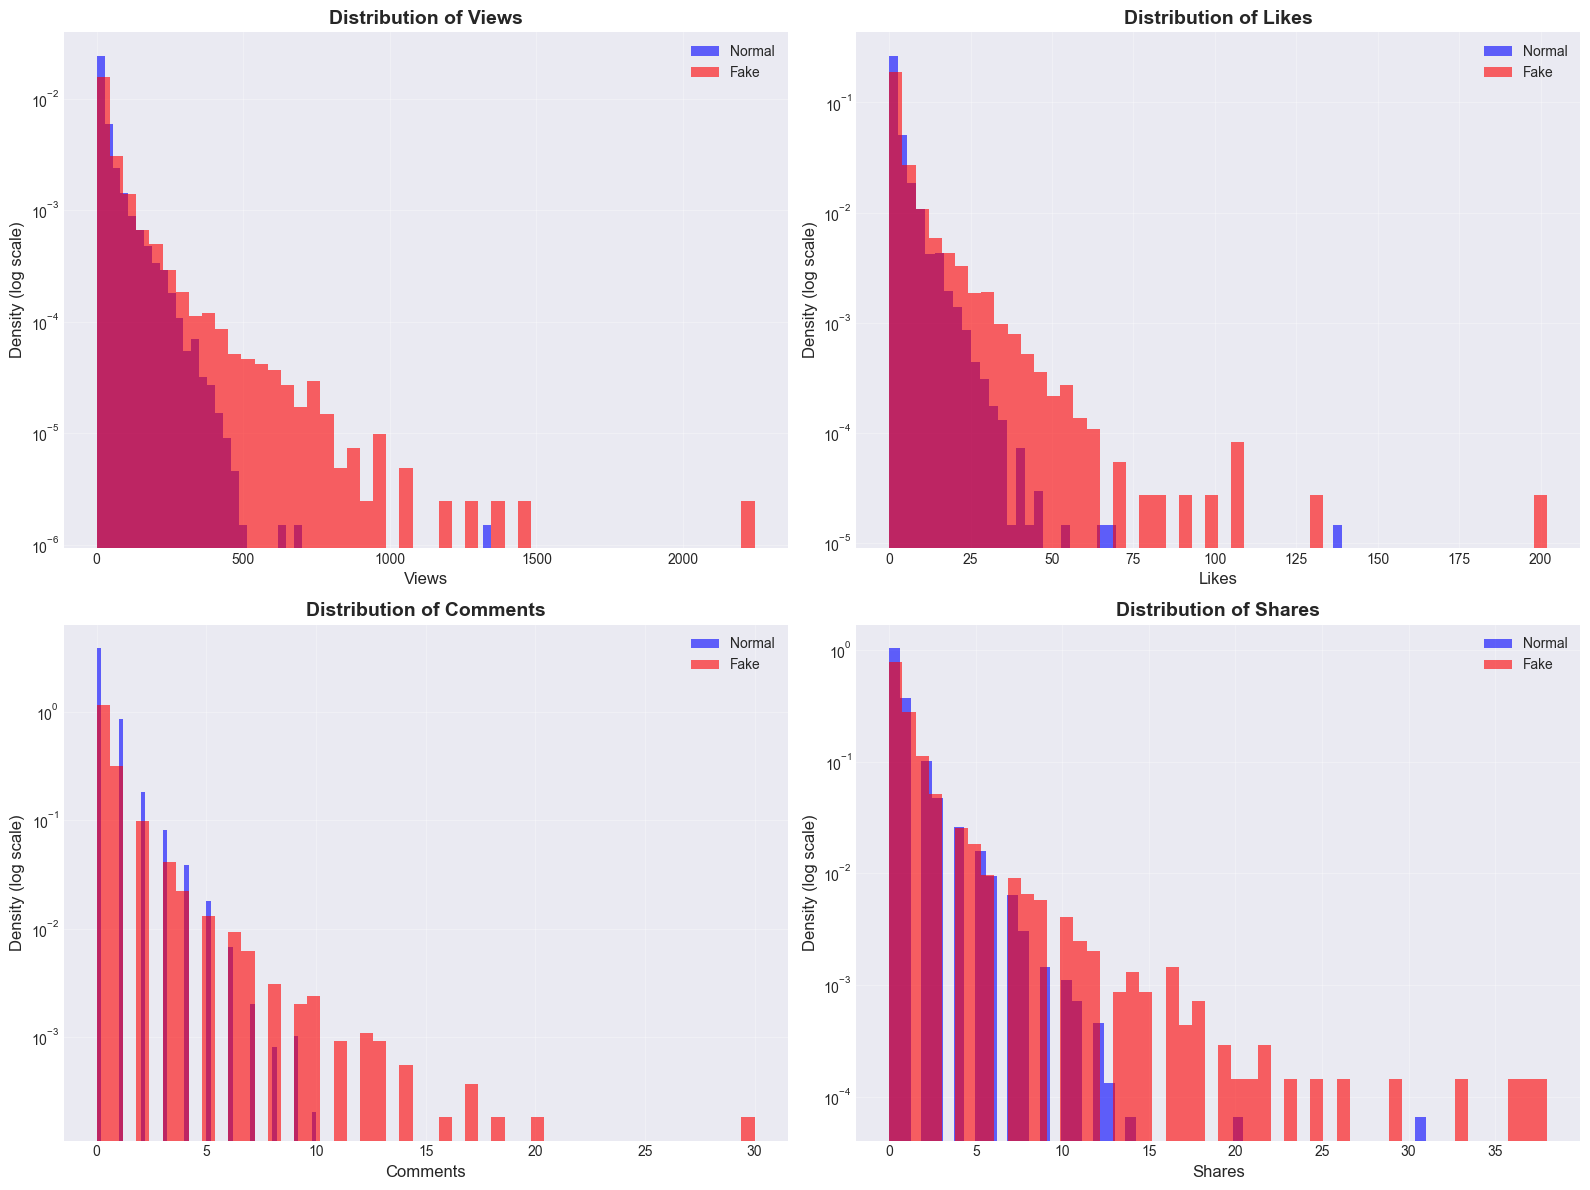

Graphique sauvegarde: 01_exploration_01_plot.png

Mean values by label:
            views     likes  comments    shares
label                                          
fake    53.098325  4.022597  0.611772  0.993937
normal  35.622921  2.425228  0.353433  0.660429

Median values by label:
        views  likes  comments  shares
label                                 
fake     16.0    1.0       0.0     0.0
normal   16.0    1.0       0.0     0.0


In [4]:
# create histograms for each metricfig, axes = plt.subplots(2, 2, figsize=(16, 12))axes = axes.flatten()for idx, metric in enumerate(metrics):    ax = axes[idx]        # plot histograms for normal and fake    normal_data = df[df['label'] == 'normal'][metric].dropna()    fake_data = df[df['label'] == 'fake'][metric].dropna()        if len(normal_data) > 0 and len(fake_data) > 0:        ax.hist(normal_data, bins=50, alpha=0.6, label='Normal', color='blue', density=True)        ax.hist(fake_data, bins=50, alpha=0.6, label='Fake', color='red', density=True)        ax.set_yscale('log')    else:        ax.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax.transAxes)        ax.set_xlabel(metric.capitalize(), fontsize=12)    ax.set_ylabel('Density (log scale)', fontsize=12)    ax.set_title(f'Distribution of {metric.capitalize()}', fontsize=14, fontweight='bold')    ax.legend()    ax.grid(True, alpha=0.3)plt.tight_layout()plt.savefig(output_dir / "01_exploration_01_plot.png", dpi=150, bbox_inches='tight')plt.show()if HAS_IPYTHON and (output_dir / "01_exploration_01_plot.png").exists():    display(Image(str(output_dir / "01_exploration_01_plot.png")))print("Graphique sauvegarde: 01_exploration_01_plot.png")# print statisticsprint("\nMean values by label:")print(df.groupby('label')[metrics].mean())print("\nMedian values by label:")print(df.groupby('label')[metrics].median())

## 4. Average Temporal Patterns

Compare average engagement curves over time for normal vs fake patterns.


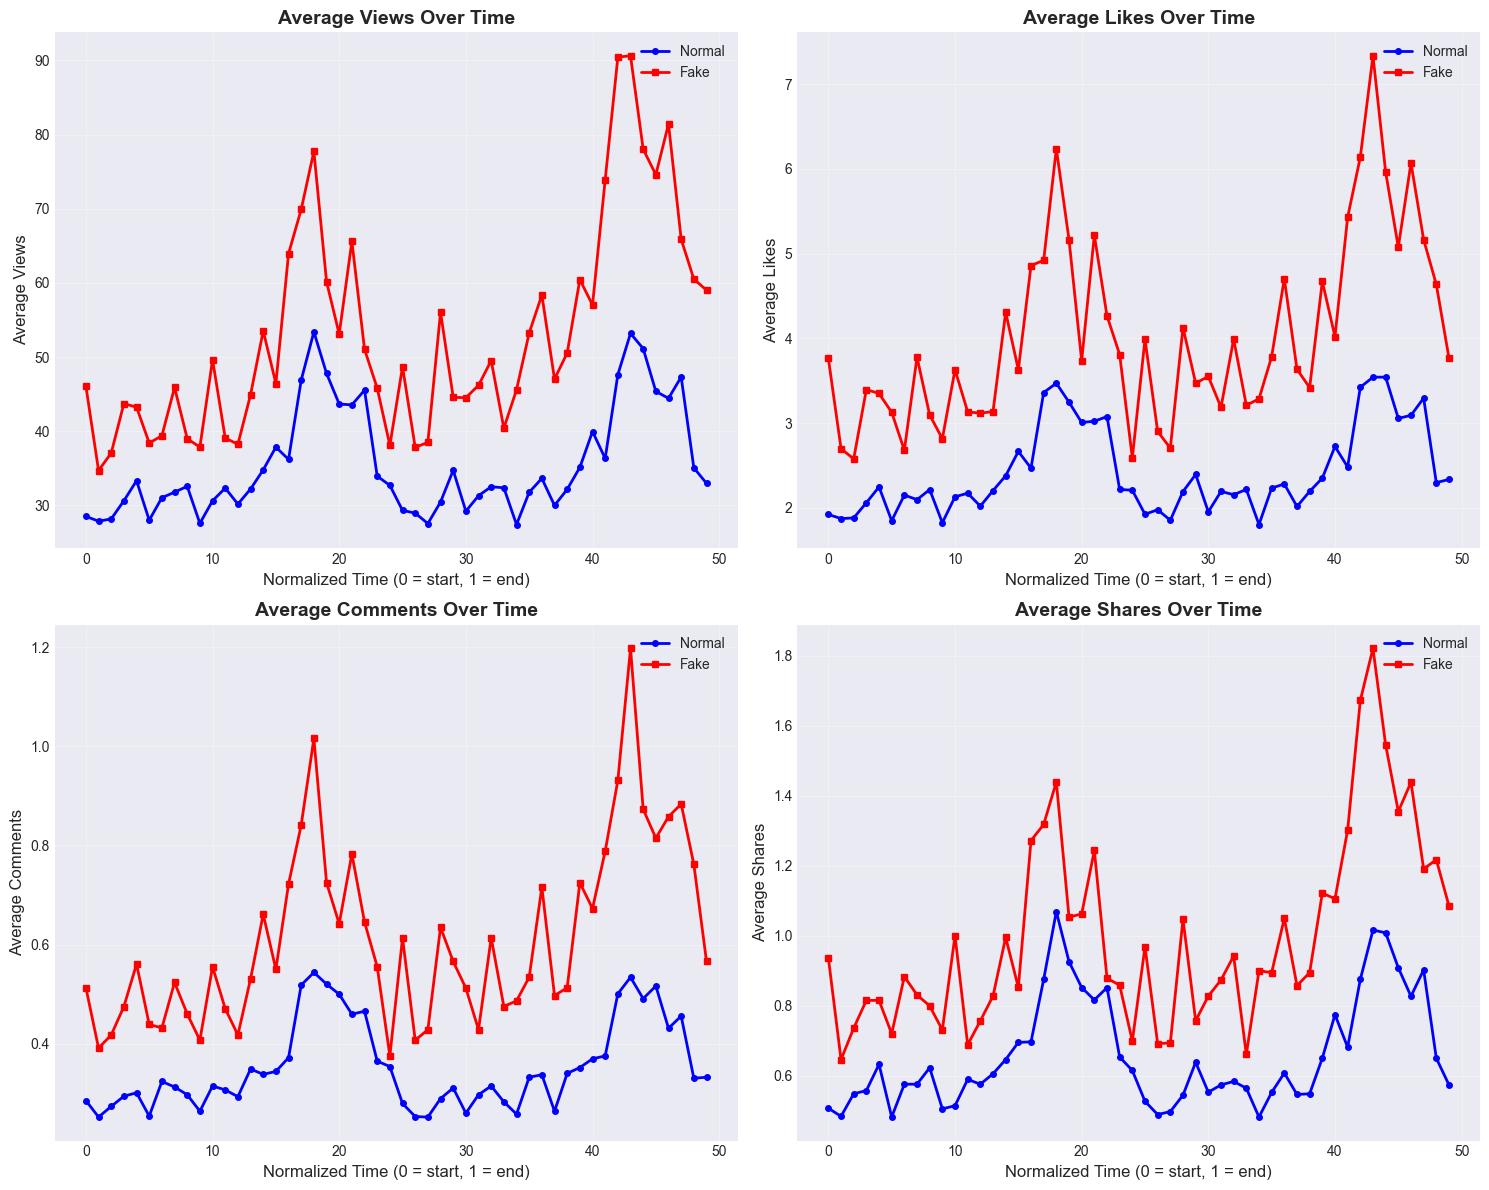

In [5]:
# normalize time for each video (0 to 1)df_normalized_time = df.copy()df_normalized_time['time_normalized'] = df_normalized_time.groupby('id')['timestamp'].transform(    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0)# create time bins for averagingn_bins = 50df_normalized_time['time_bin'] = pd.cut(df_normalized_time['time_normalized'], bins=n_bins, labels=False)# calculate average curves by labelavg_curves = df_normalized_time.groupby(['label', 'time_bin'])[metrics].mean().reset_index()# plot average curvesfig, axes = plt.subplots(2, 2, figsize=(15, 12))axes = axes.flatten()for idx, metric in enumerate(metrics):    ax = axes[idx]        normal_curve = avg_curves[avg_curves['label'] == 'normal']    fake_curve = avg_curves[avg_curves['label'] == 'fake']        ax.plot(normal_curve['time_bin'], normal_curve[metric],             label='Normal', linewidth=2, color='blue', marker='o', markersize=4)    ax.plot(fake_curve['time_bin'], fake_curve[metric],             label='Fake', linewidth=2, color='red', marker='s', markersize=4)        ax.set_xlabel('Normalized Time (0 = start, 1 = end)', fontsize=12)    ax.set_ylabel(f'Average {metric.capitalize()}', fontsize=12)    ax.set_title(f'Average {metric.capitalize()} Over Time', fontsize=14, fontweight='bold')    ax.legend()    ax.grid(True, alpha=0.3)plt.tight_layout()plt.savefig(output_dir / "01_exploration_02_plot.png", dpi=150, bbox_inches='tight')plt.show()if HAS_IPYTHON and (output_dir / "01_exploration_02_plot.png").exists():    display(Image(str(output_dir / "01_exploration_02_plot.png")))

## 5. Data Overview

Basic statistics and data quality checks.


In [6]:
# define metricsmetrics = ['views', 'likes', 'comments', 'shares']# basic statistics by labelis_fake_col = df.get('is_fake_series', None)if is_fake_col is None:    is_fake_col = (df.get('label', pd.Series(['normal'] * len(df))) == 'fake')df['label'] = is_fake_col.map({True: 'fake', False: 'normal'})print("Summary statistics by label:\n")print(df.groupby('label')[metrics].describe())# check for missing valuesprint("\nMissing values:")print(df[metrics].isna().sum())# check data typesprint("\nData types:")print(df[metrics + ['timestamp']].dtypes)

Summary statistics by label:

          views                                                         likes  \
          count       mean         std  min  25%   50%   75%     max    count   
label                                                                           
fake     9072.0  53.098325  103.036894  0.0  5.0  16.0  58.0  2244.0   9072.0   
normal  24528.0  35.622921   54.429007  0.0  5.0  16.0  39.0  1345.0  24528.0   

                  ... comments         shares                                \
            mean  ...      75%   max    count      mean       std  min  25%   
label             ...                                                         
fake    4.022597  ...      1.0  30.0   9072.0  0.993937  2.183881  0.0  0.0   
normal  2.425228  ...      0.0  10.0  24528.0  0.660429  1.284573  0.0  0.0   

                        
        50%  75%   max  
label                   
fake    0.0  1.0  38.0  
normal  0.0  1.0  31.0  

[2 rows x 32 columns]

Missing values:
vie

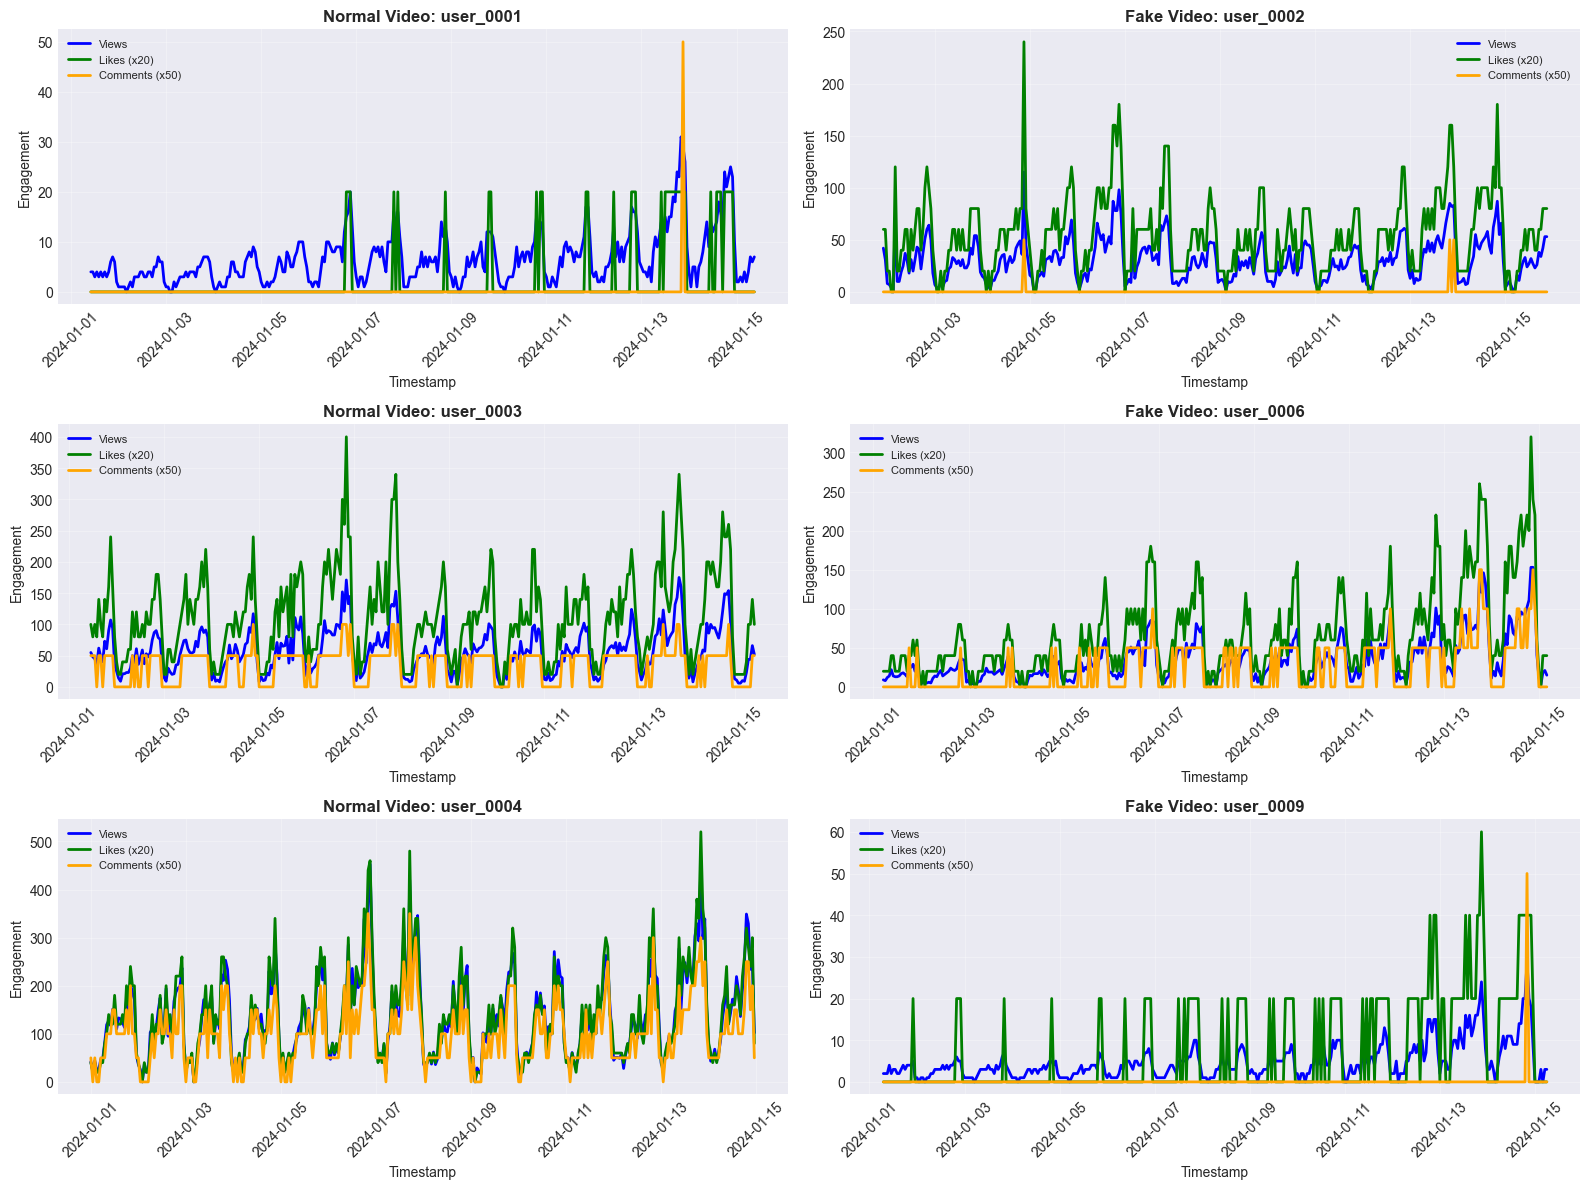

In [7]:
# select example videosnormal_ids = df[df['label'] == 'normal']['id'].unique()[:3]fake_ids = df[df['label'] == 'fake']['id'].unique()[:3]fig, axes = plt.subplots(3, 2, figsize=(16, 12))# plot normal examplesfor idx, video_id in enumerate(normal_ids):    ax = axes[idx, 0]    video_data = df[df['id'] == video_id].sort_values('timestamp')        ax.plot(video_data['timestamp'], video_data['views'],             label='Views', linewidth=2, color='blue')    ax.plot(video_data['timestamp'], video_data['likes'] * 20,             label='Likes (x20)', linewidth=2, color='green')    ax.plot(video_data['timestamp'], video_data['comments'] * 50,             label='Comments (x50)', linewidth=2, color='orange')        ax.set_title(f'Normal Video: {video_id}', fontsize=12, fontweight='bold')    ax.set_xlabel('Timestamp', fontsize=10)    ax.set_ylabel('Engagement', fontsize=10)    ax.legend(fontsize=8)    ax.grid(True, alpha=0.3)    ax.tick_params(axis='x', rotation=45)# plot fake examplesfor idx, video_id in enumerate(fake_ids):    ax = axes[idx, 1]    video_data = df[df['id'] == video_id].sort_values('timestamp')        ax.plot(video_data['timestamp'], video_data['views'],             label='Views', linewidth=2, color='blue')    ax.plot(video_data['timestamp'], video_data['likes'] * 20,             label='Likes (x20)', linewidth=2, color='green')    ax.plot(video_data['timestamp'], video_data['comments'] * 50,             label='Comments (x50)', linewidth=2, color='orange')        ax.set_title(f'Fake Video: {video_id}', fontsize=12, fontweight='bold')    ax.set_xlabel('Timestamp', fontsize=10)    ax.set_ylabel('Engagement', fontsize=10)    ax.legend(fontsize=8)    ax.grid(True, alpha=0.3)    ax.tick_params(axis='x', rotation=45)plt.tight_layout()plt.savefig(output_dir / "01_exploration_03_plot.png", dpi=150, bbox_inches='tight')plt.show()if HAS_IPYTHON and (output_dir / "01_exploration_03_plot.png").exists():    display(Image(str(output_dir / "01_exploration_03_plot.png")))

## 3.1. Spectacular Anomaly Visualization - Red Zones & Spikes

Visualize fake engagement patterns with red anomaly zones and spikes highlighted.


In [ ]:
# spectacular visualization with red zones and spikesif 'is_anomaly_window' in df.columns:    # select fake series with anomalies    fake_users = df[df.get('is_fake_series', df.get('label') == 'fake')]['id'].unique()    if len(fake_users) > 0:        sample_user_id = fake_users[0]        sample_series = df[df['id'] == sample_user_id].sort_values('timestamp')                # get anomaly mask        anomaly_mask = sample_series.get('is_anomaly_window', pd.Series([False] * len(sample_series))).values                # create spectacular visualization        fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)                # top: views with red zones        ax1 = axes[0]        fig_viz, ax_viz = plot_series_with_anomalies(            sample_series['timestamp'],            sample_series['views'],            anomaly_mask,            title=f'Fake Engagement Pattern - User {sample_user_id} (Red Zones = Anomalies)',            show_zones=True,            spike_color='red',            normal_color='blue'        )        ax1.remove()        ax1 = ax_viz        axes[0] = ax1                # bottom: likes with red zones        ax2 = axes[1]        fig_viz2, ax_viz2 = plot_series_with_anomalies(            sample_series['timestamp'],            sample_series['likes'],            anomaly_mask,            title=f'Likes Pattern - User {sample_user_id} (Red Zones = Anomalies)',            show_zones=True,            spike_color='red',            normal_color='green'        )        ax2.remove()        ax2 = ax_viz2        axes[1] = ax2                plt.tight_layout()        plt.savefig(output_dir / "01_spectacular_anomalies_red_zones.png", dpi=150, bbox_inches='tight')        plt.show()        if HAS_IPYTHON and (output_dir / "01_spectacular_anomalies_red_zones.png").exists():            display(Image(str(output_dir / "01_spectacular_anomalies_red_zones.png")))    else:        print("No fake users found.")else:    print("is_anomaly_window column not found in dataset.")

## 6. Pattern Distinctness Analysis

Analyze how distinct fake patterns are from normal patterns using statistical measures.


## 7. Engagement Metrics Comparison Heatmap

Compare mean engagement metrics between normal and fake patterns using a heatmap.


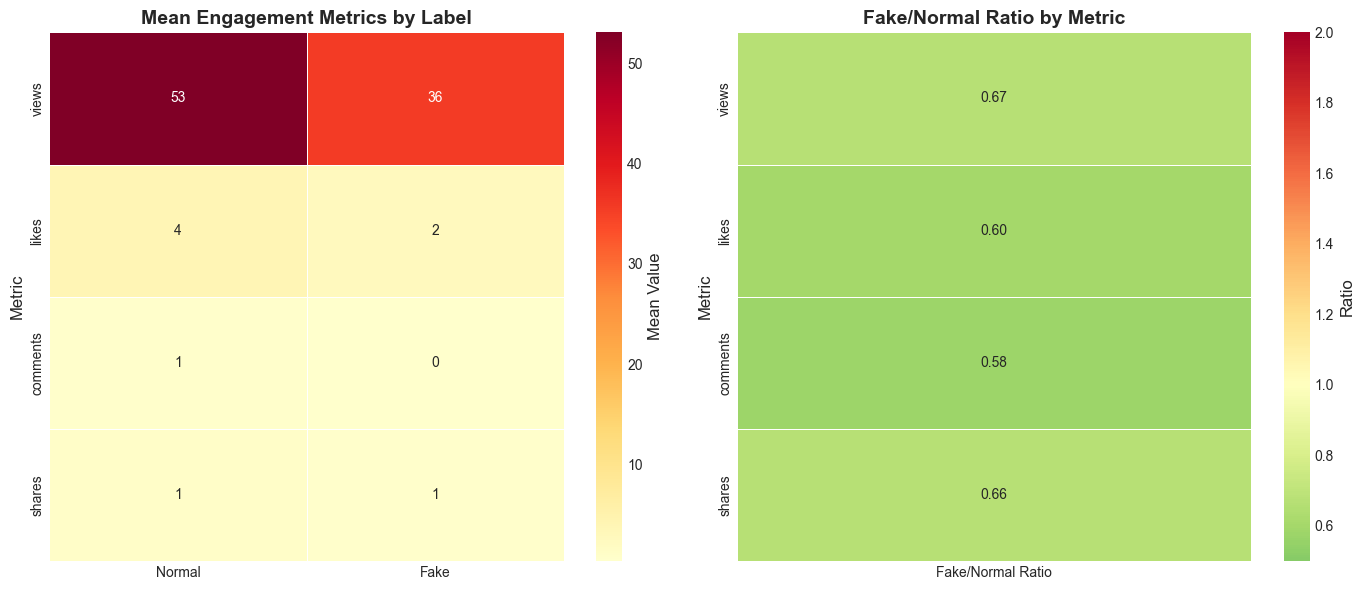

Mean values comparison:
             Normal       Fake
views     53.098325  35.622921
likes      4.022597   2.425228
comments   0.611772   0.353433
shares     0.993937   0.660429

Fake/Normal ratios:
          Fake/Normal Ratio
views              0.670886
likes              0.602901
comments           0.577718
shares             0.664457


In [8]:
# create comparison heatmapcomparison_data = df.groupby('label')[metrics].agg(['mean', 'std', 'max', 'min']).Tcomparison_data.columns = [f"{col[0]}_{col[1]}" for col in comparison_data.columns]# create mean values heatmapmean_comparison = df.groupby('label')[metrics].mean().Tmean_comparison.columns = ['Normal', 'Fake']fig, axes = plt.subplots(1, 2, figsize=(14, 6))# absolute valuessns.heatmap(mean_comparison, annot=True, fmt='.0f', cmap='YlOrRd',             cbar_kws={'label': 'Mean Value'}, ax=axes[0], linewidths=0.5)axes[0].set_title('Mean Engagement Metrics by Label', fontsize=14, fontweight='bold')axes[0].set_ylabel('Metric', fontsize=12)# normalized (fake/normal ratio)ratio_comparison = (mean_comparison['Fake'] / (mean_comparison['Normal'] + 1e-6)).to_frame('Fake/Normal Ratio')sns.heatmap(ratio_comparison, annot=True, fmt='.2f', cmap='RdYlGn_r',             center=1, vmin=0.5, vmax=2, cbar_kws={'label': 'Ratio'},             ax=axes[1], linewidths=0.5)axes[1].set_title('Fake/Normal Ratio by Metric', fontsize=14, fontweight='bold')axes[1].set_ylabel('Metric', fontsize=12)plt.tight_layout()plt.savefig(output_dir / "01_exploration_04_plot.png", dpi=150, bbox_inches='tight')plt.show()if HAS_IPYTHON and (output_dir / "01_exploration_04_plot.png").exists():    display(Image(str(output_dir / "01_exploration_04_plot.png")))print("Mean values comparison:")print(mean_comparison)print("\nFake/Normal ratios:")print(ratio_comparison)

Per-video statistics comparison:

        views_mean  likes_mean  comments_mean  shares_mean  views_cv  \
label                                                                  
fake     53.098325    4.022597       0.611772     0.993937  0.839022   
normal   35.622921    2.425228       0.353433     0.660429  0.645278   

        likes_cv  comments_cv  shares_cv  
label                                     
fake    1.250887     3.258481   3.650563  
normal  1.313671     2.804007   2.192155  


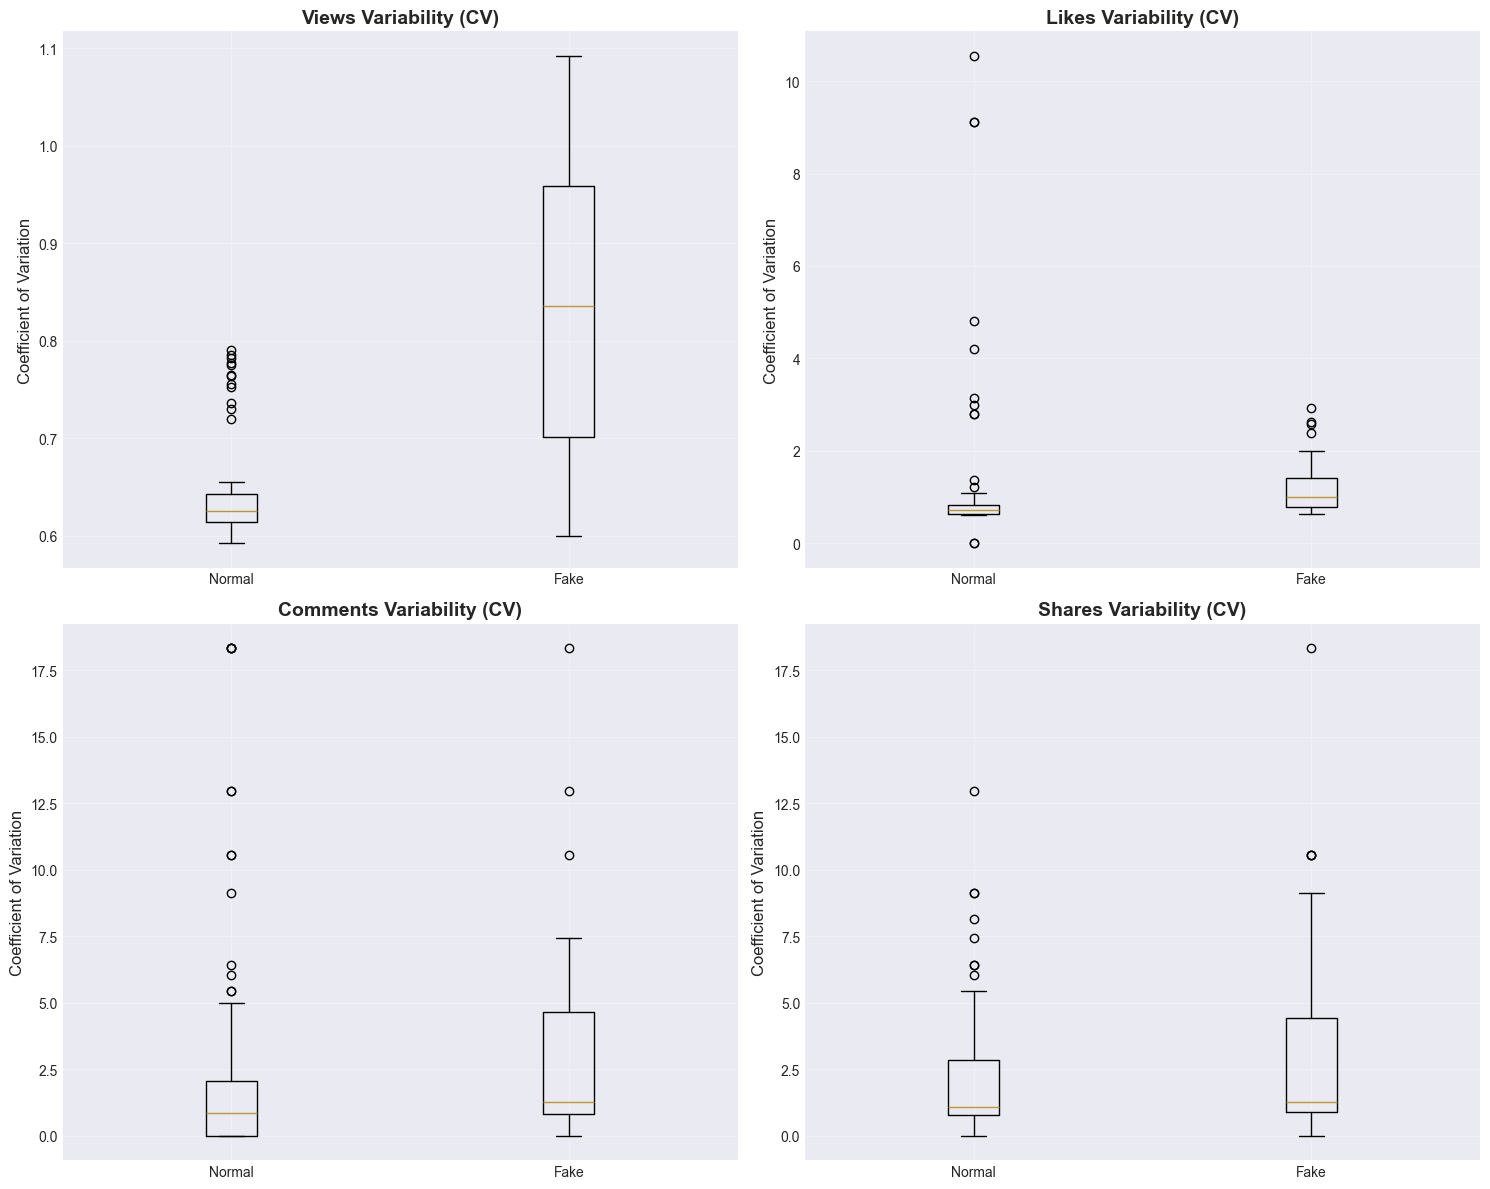

In [9]:
# calculate per-video statisticsvideo_stats = df.groupby(['id', 'label']).agg({    'views': ['mean', 'std', 'max', 'min'],    'likes': ['mean', 'std', 'max', 'min'],    'comments': ['mean', 'std', 'max', 'min'],    'shares': ['mean', 'std', 'max', 'min']}).reset_index()video_stats.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in video_stats.columns.values]# calculate coefficient of variation (std/mean) as a measure of variabilityfor metric in metrics:    mean_col = f'{metric}_mean'    std_col = f'{metric}_std'    cv_col = f'{metric}_cv'    video_stats[cv_col] = video_stats[std_col] / (video_stats[mean_col] + 1e-6)# compare statistics between normal and fakeprint("Per-video statistics comparison:\n")comparison_cols = [col for col in video_stats.columns if any(m in col for m in metrics) and ('mean' in col or 'cv' in col)]print(video_stats.groupby('label')[comparison_cols].mean())# plot comparisonfig, axes = plt.subplots(2, 2, figsize=(15, 12))axes = axes.flatten()for idx, metric in enumerate(metrics):    ax = axes[idx]        normal_cv = video_stats[video_stats['label'] == 'normal'][f'{metric}_cv']    fake_cv = video_stats[video_stats['label'] == 'fake'][f'{metric}_cv']        ax.boxplot([normal_cv.dropna(), fake_cv.dropna()],                labels=['Normal', 'Fake'])    ax.set_ylabel('Coefficient of Variation', fontsize=12)    ax.set_title(f'{metric.capitalize()} Variability (CV)', fontsize=14, fontweight='bold')    ax.grid(True, alpha=0.3)plt.tight_layout()plt.savefig(output_dir / "01_exploration_05_plot.png", dpi=150, bbox_inches='tight')plt.show()if HAS_IPYTHON and (output_dir / "01_exploration_05_plot.png").exists():    display(Image(str(output_dir / "01_exploration_05_plot.png")))

## 8. Correlation Heatmaps - Normal vs Fake

Compare correlation patterns between engagement metrics for normal and fake patterns.


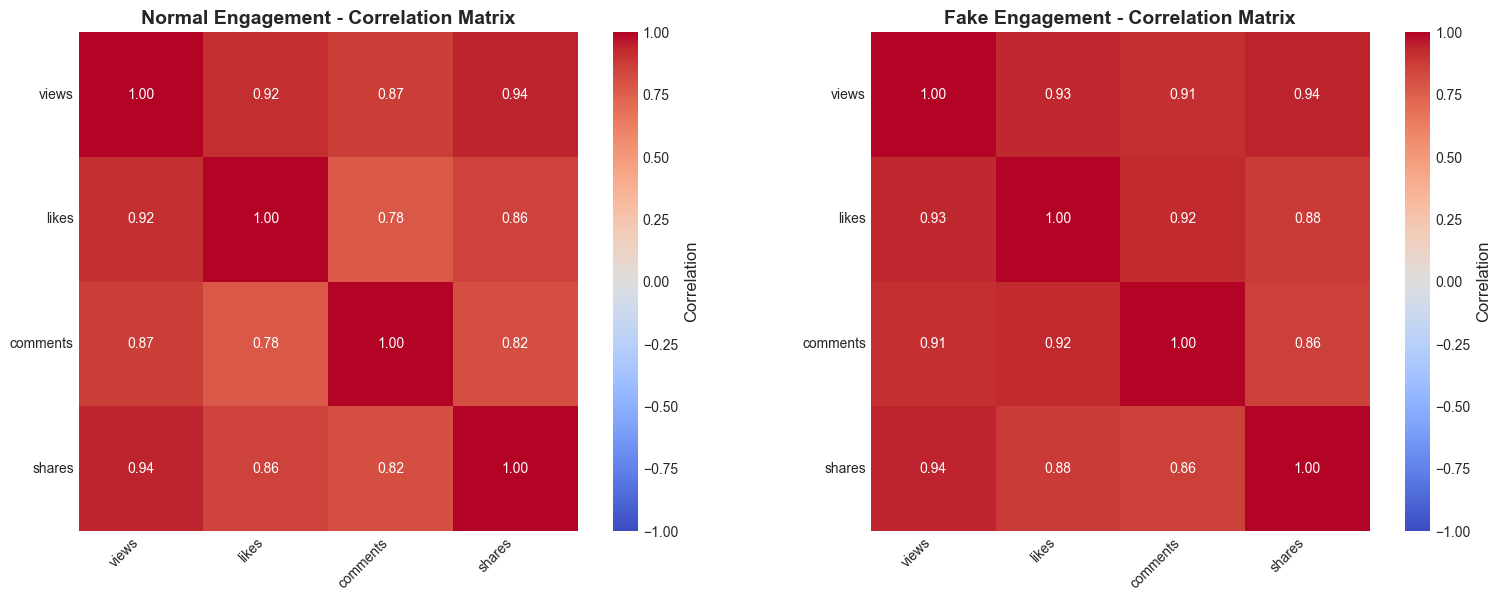

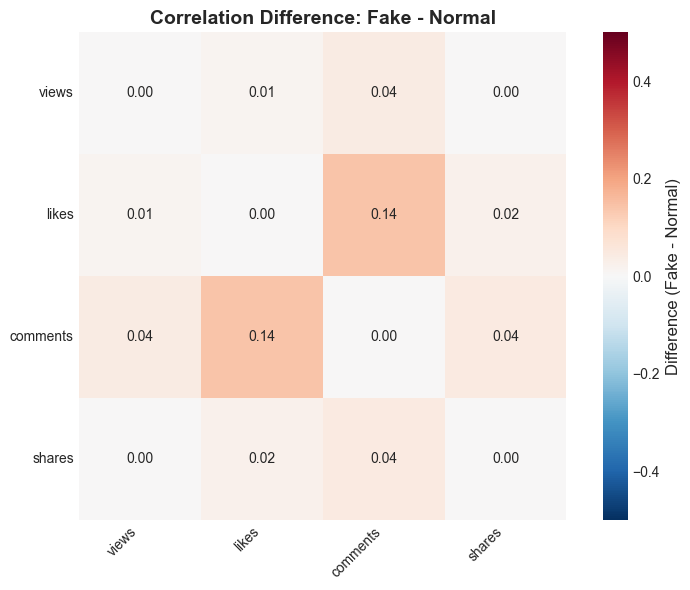

Correlation differences (Fake - Normal):
          views  likes  comments  shares
views     0.000  0.014     0.041   0.003
likes     0.014  0.000     0.143   0.023
comments  0.041  0.143     0.000   0.044
shares    0.003  0.023     0.044   0.000


In [10]:
# compute correlation matricesnormal_df = df[df['label'] == 'normal'][metrics]fake_df = df[df['label'] == 'fake'][metrics]normal_corr = normal_df.corr()fake_corr = fake_df.corr()# plot correlation heatmaps side by sidefig, axes = plt.subplots(1, 2, figsize=(16, 6))# normal correlation heatmapsns.heatmap(normal_corr, annot=True, fmt='.2f', cmap='coolwarm',             center=0, vmin=-1, vmax=1, square=True, ax=axes[0],            cbar_kws={'label': 'Correlation'})axes[0].set_title('Normal Engagement - Correlation Matrix', fontsize=14, fontweight='bold')axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)# fake correlation heatmapsns.heatmap(fake_corr, annot=True, fmt='.2f', cmap='coolwarm',             center=0, vmin=-1, vmax=1, square=True, ax=axes[1],            cbar_kws={'label': 'Correlation'})axes[1].set_title('Fake Engagement - Correlation Matrix', fontsize=14, fontweight='bold')axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')axes[1].set_yticklabels(axes[1].get_ytiif HAS_IPYTHON and output_dir / "01_exploration_06_plot.png".exists():    display(Image(str(output_dir / "01_exploration_06_plot.png")))if HAS_IPYTHON and (output_dir / "01_exploration_06_plot.png").exists():    display(Image(str(output_dir / "01_exploration_06_plot.png")))# difference heatmapcorr_diff = fake_corr - normal_corrfig, ax = plt.subplots(1, 1, figsize=(8, 6))sns.heatmap(corr_diff, annot=True, fmt='.2f', cmap='RdBu_r',             center=0, vmin=-0.5, vmax=0.5, square=True, ax=ax,            cbar_kws={'label': 'Difference (Fake - Normal)'})ax.set_title('Correlation Difference: Fake - Normal', fontsize=14, fontweight='bold')ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')ax.set_yticklabels(ax.get_yticklabels(), rotation=0)plt.tight_layout()plt.savefig(output_dir / "01_exploration_07_plot.png", dpi=150, bbox_inches='tight')plt.show()if HAS_IPYTHON and (output_dir / "01_exploration_07_plot.png").exists():    display(Image(str(output_dir / "01_exploration_07_plot.png")))print("Correlation differences (Fake - Normal):")print(corr_diff.round(3))

## 9. Spectrogramme / FFT - Détection de Patterns Réguliers

Analyse fréquentielle pour détecter les patterns réguliers (bots synchronisés).


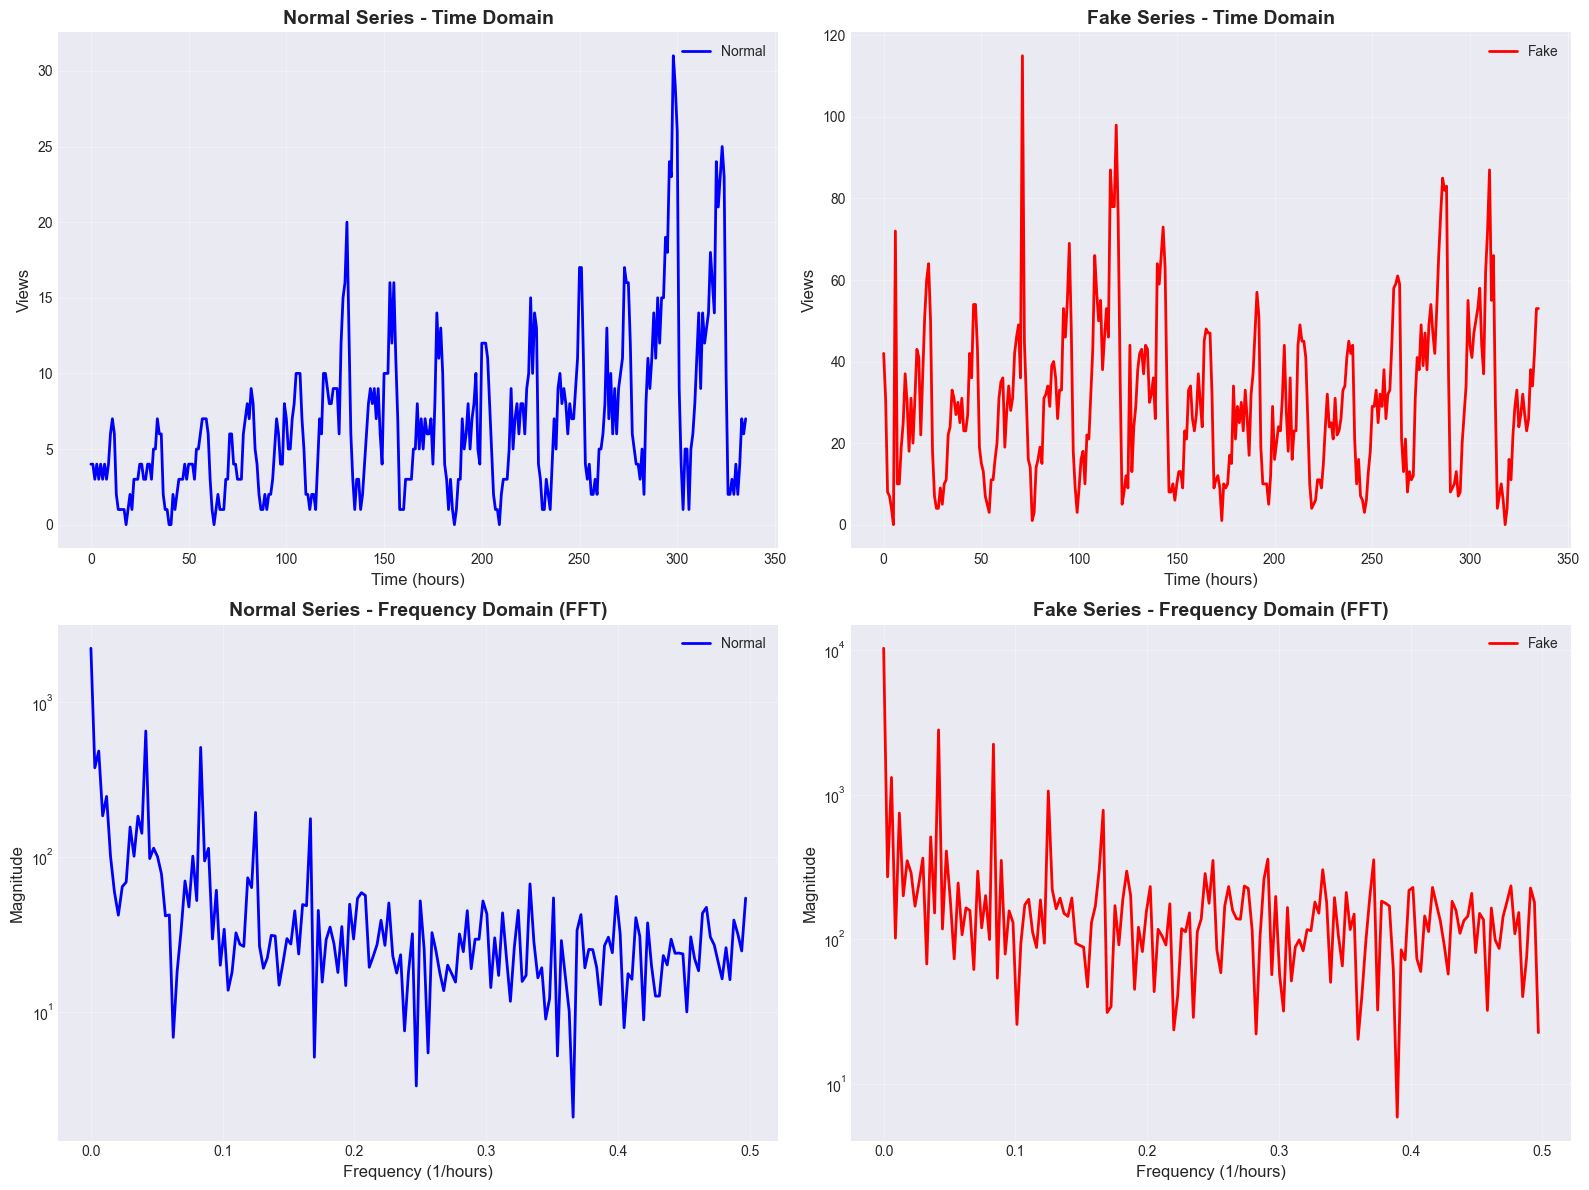

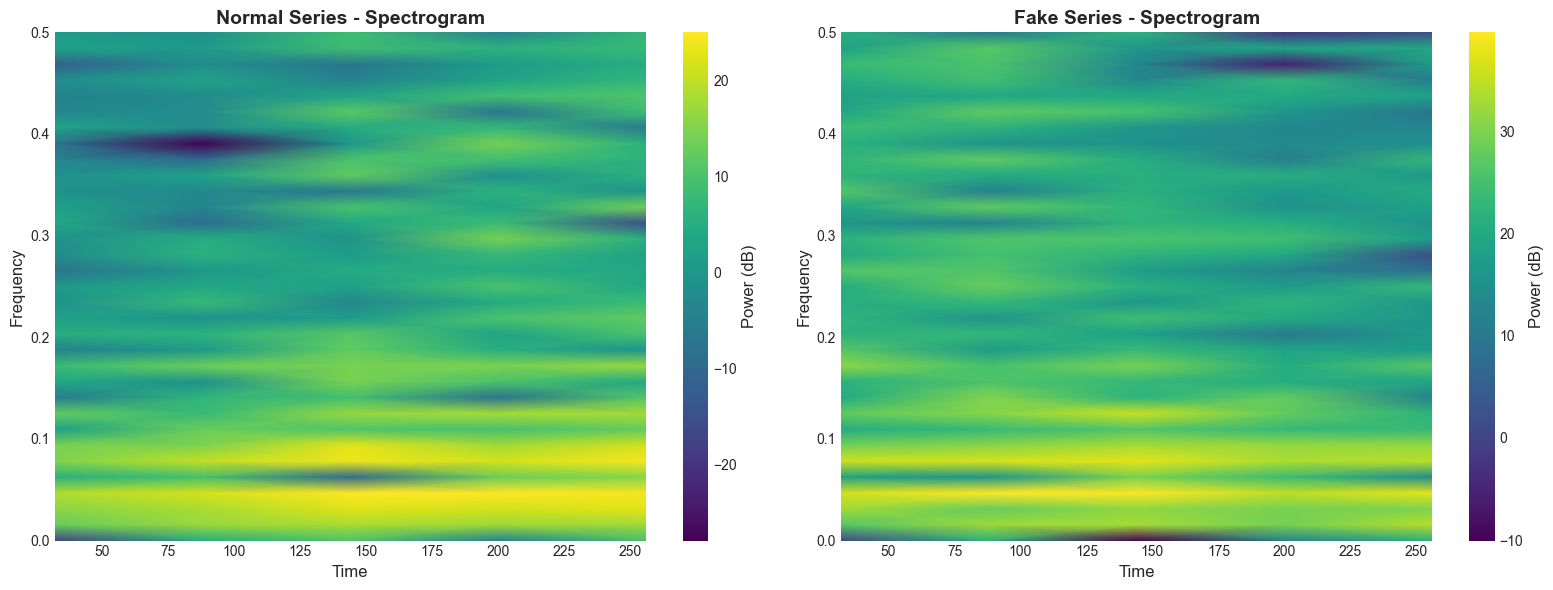

In [11]:
# FFT analysis for detecting regular patterns (bot-like behavior)from scipy import signalfrom scipy.fft import fft, fftfreq# select example seriesnormal_sample = df[df['label'] == 'normal']['id'].unique()[0]fake_sample = df[df['label'] == 'fake']['id'].unique()[0]normal_series = df[df['id'] == normal_sample].sort_values('timestamp')['views'].valuesfake_series = df[df['id'] == fake_sample].sort_values('timestamp')['views'].values# compute FFTnormal_fft = np.abs(fft(normal_series))fake_fft = np.abs(fft(fake_series))freqs = fftfreq(len(normal_series), 1.0)  # assuming hourly data# plot FFT comparisonfig, axes = plt.subplots(2, 2, figsize=(16, 12))# time seriesaxes[0, 0].plot(normal_series, label='Normal', linewidth=2, color='blue')axes[0, 0].set_title('Normal Series - Time Domain', fontsize=14, fontweight='bold')axes[0, 0].set_xlabel('Time (hours)', fontsize=12)axes[0, 0].set_ylabel('Views', fontsize=12)axes[0, 0].legend()axes[0, 0].grid(True, alpha=0.3)axes[0, 1].plot(fake_series, label='Fake', linewidth=2, color='red')axes[0, 1].set_title('Fake Series - Time Domain', fontsize=14, fontweight='bold')axes[0, 1].set_xlabel('Time (hours)', fontsize=12)axes[0, 1].set_ylabel('Views', fontsize=12)axes[0, 1].legend()axes[0, 1].grid(True, alpha=0.3)# FFT magnitudepositive_freqs = freqs[:len(freqs)//2]axes[1, 0].plot(positive_freqs, normal_fft[:len(normal_fft)//2],                 label='Normal', linewidth=2, color='blue')axes[1, 0].set_title('Normal Series - Frequency Domain (FFT)', fontsize=14, fontweight='bold')axes[1, 0].set_xlabel('Frequency (1/hours)', fontsize=12)axes[1, 0].set_ylabel('Magnitude', fontsize=12)axes[1, 0].set_yscale('log')axes[1, 0].legend()axes[1, 0].grid(True, alpha=0.3)axes[1, 1].plot(positive_freqs, fake_fft[:len(fake_fft)//2],                 label='Fake', linewidth=2, color='red')axes[1, 1].set_title('Fake Series - Frequency Domain (FFT)', fontsize=14, fontweight='bold')axes[1, 1].set_xlabel('Frequency (1/hours)', fontsize=12)axes[1, 1].set_ylabel('Magnitude', fontsize=12)axes[1, 1].set_yscale('log')axes[1, 1].leight')plt.show()if HAS_IPYTHON and output_dir / "01_exploration_08_fft.png".exists():    display(Image(str(output_dir / "01_exploration_08_fft.png")))if HAS_IPYTHON and (output_dir / "01_exploration_08_fft.png").exists():    display(Image(str(output_dir / "01_exploration_08_fft.png")))# spectrogramfig, axes = plt.subplots(1, 2, figsize=(16, 6))f_normal, t_normal, Sxx_normal = signal.spectrogram(normal_series, nperseg=min(64, len(normal_series)//4))im1 = axes[0].pcolormesh(t_normal, f_normal, 10 * np.log10(Sxx_normal + 1e-10), shading='gouraud', cmap='viridis')axes[0].set_title('Normal Series - Spectrogram', fontsize=14, fontweight='bold')axes[0].set_xlabel('Time', fontsize=12)axes[0].set_ylabel('Frequency', fontsize=12)plt.colorbar(im1, ax=axes[0], label='Power (dB)')f_fake, t_fake, Sxx_fake = signal.spectrogram(fake_series, nperseg=min(64, len(fake_series)//4))im2 = axes[1].pcolormesh(t_fake, f_fake, 10 * np.log10(Sxx_fake + 1e-10), shading='gouraud', cmap='viridis')axes[1].set_title('Fake Series - Spectrogram', fontsize=14, fontweight='bold')axes[1].set_xlabel('Time', fontsize=12)axes[1].set_ylabel('Frequency', fontsize=12)plt.colorbar(im2, ax=axes[1], label='Power (dB)')plt.tight_layout()plt.savefig(output_dir / "01_exploration_09_spectrogram.png", dpi=150, bbox_inches='tight')plt.show()if HAS_IPYTHON and (output_dir / "01_exploration_09_spectrogram.png").exists():    display(Image(str(output_dir / "01_exploration_09_spectrogram.png")))

## 10. Distribution des Amplitudes

Analyse de la distribution des amplitudes pour distinguer normal vs fake.


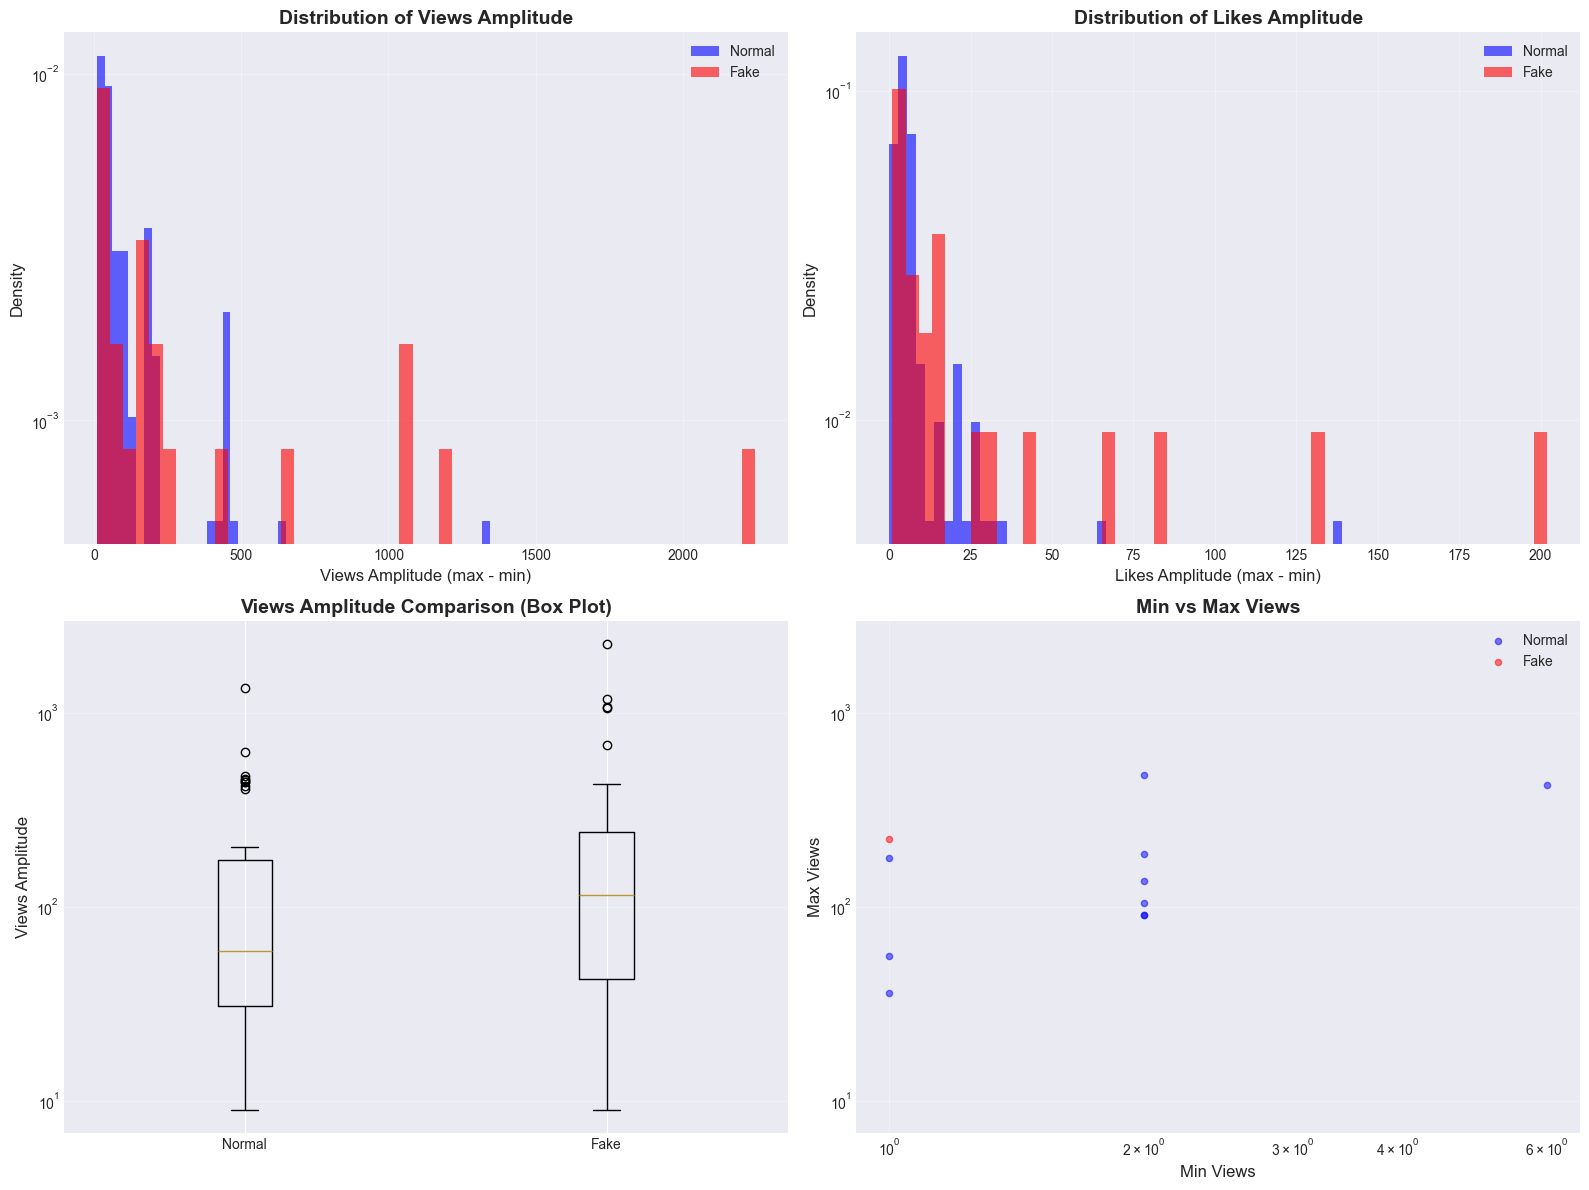

In [12]:
# distribution des amplitudes (max - min par série)amplitude_stats = df.groupby(['id', 'label']).agg({    'views': ['max', 'min', lambda x: x.max() - x.min()],    'likes': ['max', 'min', lambda x: x.max() - x.min()],}).reset_index()amplitude_stats.columns = ['id', 'label', 'views_max', 'views_min', 'views_amplitude',                           'likes_max', 'likes_min', 'likes_amplitude']# plot amplitude distributionsfig, axes = plt.subplots(2, 2, figsize=(16, 12))# views amplitudeax = axes[0, 0]normal_amp = amplitude_stats[amplitude_stats['label'] == 'normal']['views_amplitude'].dropna()fake_amp = amplitude_stats[amplitude_stats['label'] == 'fake']['views_amplitude'].dropna()ax.hist(normal_amp, bins=50, alpha=0.6, label='Normal', color='blue', density=True)ax.hist(fake_amp, bins=50, alpha=0.6, label='Fake', color='red', density=True)ax.set_xlabel('Views Amplitude (max - min)', fontsize=12)ax.set_ylabel('Density', fontsize=12)ax.set_title('Distribution of Views Amplitude', fontsize=14, fontweight='bold')ax.set_yscale('log')ax.legend()ax.grid(True, alpha=0.3)# likes amplitudeax = axes[0, 1]normal_amp_likes = amplitude_stats[amplitude_stats['label'] == 'normal']['likes_amplitude'].dropna()fake_amp_likes = amplitude_stats[amplitude_stats['label'] == 'fake']['likes_amplitude'].dropna()ax.hist(normal_amp_likes, bins=50, alpha=0.6, label='Normal', color='blue', density=True)ax.hist(fake_amp_likes, bins=50, alpha=0.6, label='Fake', color='red', density=True)ax.set_xlabel('Likes Amplitude (max - min)', fontsize=12)ax.set_ylabel('Density', fontsize=12)ax.set_title('Distribution of Likes Amplitude', fontsize=14, fontweight='bold')ax.set_yscale('log')ax.legend()ax.grid(True, alpha=0.3)# box plot comparisonax = axes[1, 0]box_data = [normal_amp.dropna(), fake_amp.dropna()]ax.boxplot(box_data, labels=['Normal', 'Fake'])ax.set_ylabel('Views Amplitude', fontsize=12)ax.set_title('Views Amplitude Comparison (Box Plot)', fontsize=14, fontweight='bold')ax.set_yscale('log')ax.grid(True, alpha=0.3, axis='y')# scatter: max vs minax = axes[1, 1]normal_data = amplitude_stats[amplitude_stats['label'] == 'normal']fake_data = amplitude_stats[amplitude_stats['label'] == 'fake']ax.scatter(normal_data['views_min'], normal_data['views_max'],            alpha=0.5, label='Normal', color='blue', s=20)ax.scatter(fake_data['views_min'], fake_data['views_max'],            alpha=0.5, label='Fake', color='red', s=20)ax.set_xlabel('Min Views', fontsize=12)ax.set_ylabel('Max Views', fontsize=12)ax.set_title('Min vs Max Views', fontsize=14, fontweight='bold')ax.set_xscale('log')ax.set_yscale('log')ax.legend()ax.grid(True, alpha=0.3)plt.tight_layout()plt.savefig(output_dir / "01_exploration_10_amplitude_distribution.png", dpi=150, bbox_inches='tight')plt.show()if HAS_IPYTHON and (output_dir / "01_exploration_10_amplitude_distribution.png").exists():    display(Image(str(output_dir / "01_exploration_10_amplitude_distribution.png")))

## 7. Class Balance Analysis

Check if the dataset is balanced and suitable for training.


Class distribution:
label
normal    24528
fake       9072
Name: count, dtype: int64

Class proportions:
label
normal    0.73
fake      0.27
Name: proportion, dtype: float64


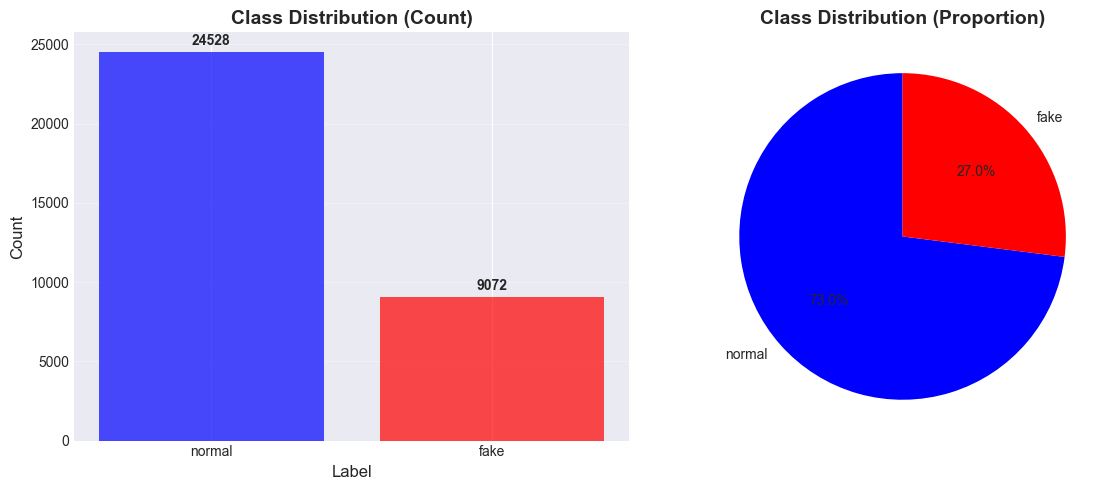


Number of unique videos per class:
label
fake      27
normal    73
Name: id, dtype: int64

Ratio (normal/fake): 2.70

Balance ratio: 2.70


In [13]:
# class distributionlabel_counts = df['label'].value_counts()label_proportions = df['label'].value_counts(normalize=True)print("Class distribution:")print(label_counts)print("\nClass proportions:")print(label_proportions)# plot class distributionfig, axes = plt.subplots(1, 2, figsize=(12, 5))# count plotaxes[0].bar(label_counts.index, label_counts.values, color=['blue', 'red'], alpha=0.7)axes[0].set_ylabel('Count', fontsize=12)axes[0].set_xlabel('Label', fontsize=12)axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')axes[0].grid(True, alpha=0.3, axis='y')# add count labels on barsfor i, v in enumerate(label_counts.values):    axes[0].text(i, v + max(label_counts.values) * 0.01, str(v),                  ha='center', va='bottom', fontweight='bold')# proportion pie chartaxes[1].pie(label_proportions.values, labels=label_proportions.index,             autopct='%1.1f%%', startangle=90, colors=['blue', 'red'])axes[1].set_title('Class Distribution (Proportion)', fontsize=14, fontweight='bold')plt.tight_layout()plt.savefig(output_dir / "01_exploration_08_plot.png", dpi=150, bbox_inches='tight')plt.show()if HAS_IPYTHON and (output_dir / "01_exploration_08_plot.png").exists():    display(Image(str(output_dir / "01_exploration_08_plot.png")))# videos per classvideos_per_class = df.groupby('label')['id'].nunique()print("\nNumber of unique videos per class:")print(videos_per_class)print(f"\nRatio (normal/fake): {videos_per_class['normal'] / videos_per_class['fake']:.2f}")# check if balanced (within reasonable range)balance_ratio = label_proportions['normal'] / label_proportions['fake']print(f"\nBalance ratio: {balance_ratio:.2f}")if 0.5 <= balance_ratio <= 2.0:    print("Dataset is reasonably balanced for training.")else:    print("Warning: Dataset may be imbalanced. Consider using class weights or resampling.")

## 8. Correlation Analysis

Examine correlations between different engagement metrics for normal vs fake patterns.


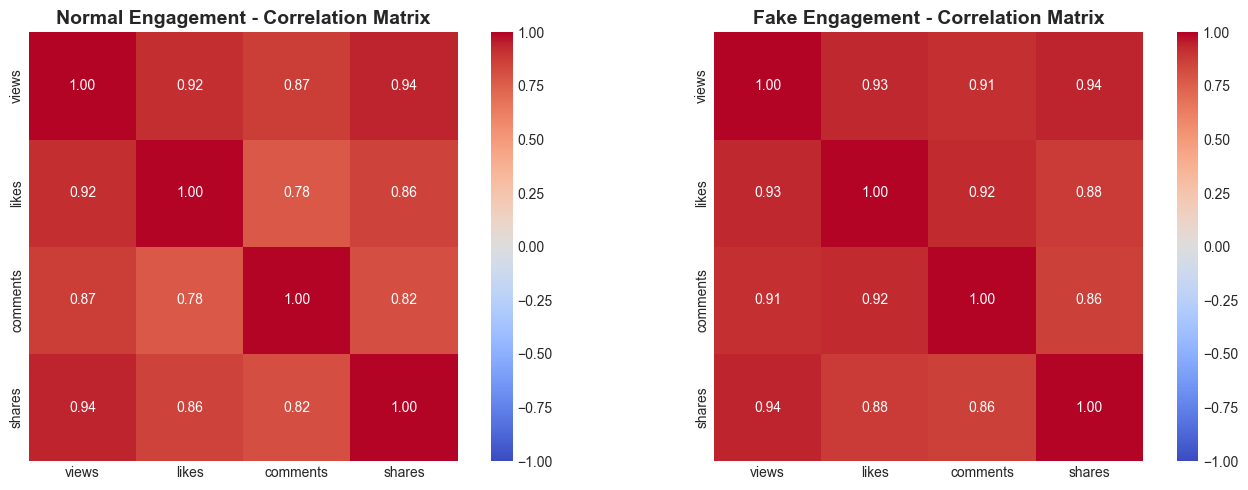

Correlation differences (Fake - Normal):
             views     likes  comments    shares
views     0.000000  0.014422  0.040851  0.002810
likes     0.014422  0.000000  0.143429  0.023464
comments  0.040851  0.143429  0.000000  0.043625
shares    0.002810  0.023464  0.043625  0.000000


In [14]:
# calculate correlation matricesnormal_df = df[df['label'] == 'normal'][metrics]fake_df = df[df['label'] == 'fake'][metrics]normal_corr = normal_df.corr()fake_corr = fake_df.corr()# plot correlation matricesfig, axes = plt.subplots(1, 2, figsize=(14, 5))sns.heatmap(normal_corr, annot=True, fmt='.2f', cmap='coolwarm',             center=0, vmin=-1, vmax=1, ax=axes[0], square=True)axes[0].set_title('Normal Engagement - Correlation Matrix', fontsize=14, fontweight='bold')sns.heatmap(fake_corr, annot=True, fmt='.2f', cmap='coolwarm',             center=0, vmin=-1, vmax=1, ax=axes[1], square=True)axes[1].set_title('Fake Engagement - Correlation Matrix', fontsize=14, fontweight='bold')plt.tight_layout()plt.savefig(output_dir / "01_exploration_09_plot.png", dpi=150, bbox_inches='tight')plt.show()if HAS_IPYTHON and (output_dir / "01_exploration_09_plot.png").exists():    display(Image(str(output_dir / "01_exploration_09_plot.png")))# compare correlationsprint("Correlation differences (Fake - Normal):")corr_diff = fake_corr - normal_corrprint(corr_diff)

## 9. Summary and Conclusions

Key findings from the exploratory analysis.


In [15]:
print("=" * 60)print("EDA SUMMARY")print("=" * 60)print(f"\n1. Dataset size: {len(df):,} rows, {df['id'].nunique()} unique videos")print(f"   - Normal: {label_counts['normal']:,} rows ({label_proportions['normal']:.1%})")print(f"   - Fake: {label_counts['fake']:,} rows ({label_proportions['fake']:.1%})")print(f"\n2. Class balance:")print(f"   - Ratio (normal/fake): {balance_ratio:.2f}")if 0.5 <= balance_ratio <= 2.0:    print("   - Status: Reasonably balanced")else:    print("   - Status: Imbalanced - consider class weights")print(f"\n3. Pattern distinctness:")for metric in metrics:    normal_mean = df[df['label'] == 'normal'][metric].mean()    fake_mean = df[df['label'] == 'fake'][metric].mean()    diff_pct = ((fake_mean - normal_mean) / normal_mean) * 100    print(f"   - {metric.capitalize()}: {diff_pct:+.1f}% difference")print(f"\n4. Data quality:")print(f"   - Missing values: {df[metrics].isna().sum().sum()}")print(f"   - Negative values: {(df[metrics] < 0).sum().sum()}")print(f"\n5. Conclusion:")print("   - Dataset is ready for feature engineering and modeling")print("   - Clear visual differences between normal and fake patterns")print("   - Temporal patterns show distinct behaviors")print("=" * 60)

EDA SUMMARY

1. Dataset size: 33,600 rows, 100 unique videos
   - Normal: 24,528 rows (73.0%)
   - Fake: 9,072 rows (27.0%)

2. Class balance:
   - Ratio (normal/fake): 2.70
   - Status: Imbalanced - consider class weights

3. Pattern distinctness:
   - Views: +49.1% difference
   - Likes: +65.9% difference
   - Comments: +73.1% difference
   - Shares: +50.5% difference

4. Data quality:
   - Missing values: 0
   - Negative values: 0

5. Conclusion:
   - Dataset is ready for feature engineering and modeling
   - Clear visual differences between normal and fake patterns
   - Temporal patterns show distinct behaviors
